<img src="http://xarray.pydata.org/en/stable/_static/dataset-diagram-logo.png" align="right" width="30%">

# Computation with Xarray

In this lesson, we discuss how to do scientific computations with xarray
objects. Our learning goals are as follows. By the end of the lesson, we will be
able to:

- Apply basic arithmetic and numpy functions to xarray DataArrays / Dataset.
- Use Xarray's label-aware reduction operations (e.g. `mean`, `sum`) weighted
  reductions.
- Apply arbitrary functions to Xarray data via `apply_ufunc`.
- Use Xarray's broadcasting to compute on arrays of different dimensionality.
- Perform "split / apply / combine" workflows in Xarray using `groupby`,
  including
  - reductions within groups
  - transformations on groups
- Use the `resample`, `rolling` and `coarsen` functions to manipulate data.


In [1]:
import expectexception
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

## Example Dataset

First we load a dataset. We will use the
[NOAA Extended Reconstructed Sea Surface Temperature (ERSST) v5](https://www.ncdc.noaa.gov/data-access/marineocean-data/extended-reconstructed-sea-surface-temperature-ersst-v5)
product, a widely used and trusted gridded compilation of of historical data
going back to 1854.

Since the data is provided via an
[OPeNDAP](https://en.wikipedia.org/wiki/OPeNDAP) server, we can load it directly
without downloading anything:


In [2]:
url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc"
# drop an unnecessary variable which complicates some operations
ds = xr.open_dataset(url, drop_variables=["time_bnds"])
# will take a minute or two to complete
ds = ds.sel(time=slice("1960", "2018")).load()
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 708)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
Data variables:
    sst      (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes:
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    geospatial_lon_min:              -1.0
    geospatial_lon_max:              359.0
    geospatial_laty_max:             89.0
    geospatial_laty_min:             -89.0
    geospatial_lat_max:              89.0
    geospatial_lat_min:              -89.0
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    cdm_data_type:                   Grid
    project:                         NOAA Extended Reconstructed Sea Surface ...
    original_publisher_url:          http://www.ncdc.noaa.gov
    References:                      https://www.ncdc.noaa.gov/data-access/ma...
    source:                          In situ data: ICOADS R3.0 before 2015, N...
    title:                           NOAA ERSSTv5 (in situ only)
    history:                         created 07/2017 by PSD data using NCEI's...
    institution:                     This version written at NOAA/ESRL PSD: o...
    citation:                        Huang et al, 2017: Extended Reconstructe...
    platform:                        Ship and Buoy SSTs from ICOADS R3.0 and ...
    standard_name_vocabulary:        CF Standard Name Table (v40, 25 January ...
    processing_level:                NOAA Level 4
    Conventions:                     CF-1.6, ACDD-1.3
    metadata_link:                   :metadata_link = https://doi.org/10.7289...
    creator_name:                    Boyin Huang (original)
    date_created:                    2017-06-30T12:18:00Z (original)
    product_version:                 Version 5
    creator_url_original:            https://www.ncei.noaa.gov
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2020-07-07
    DODS_EXTRA.Unlimited_Dimension:  time

Let's do some basic visualizations of the data, just to make sure it looks
reasonable.


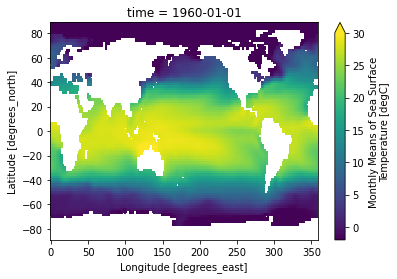

In [3]:
ds.sst[0].plot(vmin=-2, vmax=30)

## Basic Arithmetic

Xarray dataarrays and datasets work seamlessly with arithmetic operators and
numpy array functions.

For example, imagine we want to convert the temperature (given in Celsius) to
Kelvin:


In [4]:
sst_kelvin = ds.sst + 273.15
sst_kelvin

<xarray.DataArray 'sst' (time: 708, lat: 89, lon: 180)>
array([[[271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        ...,
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

       [[271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        ...,
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

       [[271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        ...,
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

       ...,

       [[271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        ...,
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

       [[271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        ...,
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

       [[271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        ...,
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01

The dimensions and coordinates were preseved following the operation.

<div class="alert alert-warning">
    <strong>Warning:</strong> Although many xarray datasets have a <code>units</code> attribute, which is used in plotting,
    Xarray does not inherently understand units. However, work is underway to integrate xarray
    with <a href="https://pint.readthedocs.io/en/0.12/">pint</a>, which will provide full unit-aware operations.
</div>

We can apply more complex functions, including numpy ufuncs, to Xarray objects.
Imagine we wanted to compute the following expression as a function of SST
($\Theta$) in Kelvin:

$$ f(\Theta) =  0.5 \ln(\Theta^2) $$


In [5]:
f = 0.5 * np.log(sst_kelvin ** 2)
f

<xarray.DataArray 'sst' (time: 708, lat: 89, lon: 180)>
array([[[5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        [5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        [5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        ...,
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan]],

       [[5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        [5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        [5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        ...,
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan]],

       [[5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        [5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        [5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        ...,
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan]],

       ...,

       [[5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        [5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        [5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        ...,
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan]],

       [[5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        [5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        [5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        ...,
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan]],

       [[5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        [5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        [5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        ...,
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan]]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01

## Applying Aribtrary Functions

It's awesome that we can call `np.log(ds)` and have it "just work". However, not
all third party libraries work this way.

In this example, we will use functions from the
[Gibbs Seawater Toolkit](https://teos-10.github.io/GSW-Python/), a package for
the thermodynamics of seawater. This package provides ufuncs that operate on
numpy arrays.


In [6]:
import gsw

# an example function
# http://www.teos-10.org/pubs/gsw/html/gsw_t90_from_t68.html
gsw.t90_from_t68?

In [7]:
gsw.t90_from_t68(ds.sst)  # -> returns a numpy array

array([[[-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        [-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        [-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        [-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        [-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        ...,
        [        nan,         nan,         nan, ...,  

It would be nice to keep our dimensions and coordinates. We can accomplish this
with `xr.apply_ufunc`.


In [8]:
xr.apply_ufunc(gsw.t90_from_t68, ds.sst)

<xarray.DataArray 'sst' (time: 708, lat: 89, lon: 180)>
array([[[-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        [-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        [-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        [-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        [-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        [-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        [-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       ...,

       [[-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        [-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        [-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        [-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        [-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        [-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        [-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 3

<div class="alert alert-info">
    <strong>Note:</strong> <code>apply_ufunc</code> is a powerful and mysterious function.
    It has many options for doing more complicated things.
    Unfortunately, we don't have time to go into more depth here.
    Please consult the [Xarray docs](http://xarray.pydata.org/en/latest/generated/xarray.apply_ufunc.html) for more details.
</div>


## Reductions

Just like in numpy, we can reduce xarray DataArrays along any number of axes:


In [9]:
f.mean(axis=0)

/home/travis/miniconda/envs/xarray/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'sst' (lat: 89, lon: 180)>
array([[5.6034575, 5.6034575, 5.603458 , ..., 5.603457 , 5.6034575,
        5.6034575],
       [5.6034575, 5.603458 , 5.603458 , ..., 5.603456 , 5.6034565,
        5.603457 ],
       [5.6034555, 5.6034565, 5.6034565, ..., 5.603456 , 5.603456 ,
        5.6034555],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

In [10]:
f.mean(axis=(1, 2))

<xarray.DataArray 'sst' (time: 708)>
array([5.6572824, 5.657586 , 5.6576443, 5.657244 , 5.6573243, 5.657293 ,
       5.6582375, 5.65893  , 5.6585946, 5.6576066, 5.65684  , 5.6569853,
       5.657431 , 5.6578784, 5.6578617, 5.6575093, 5.657374 , 5.6575465,
       5.6582036, 5.6588817, 5.6584783, 5.6574674, 5.6568427, 5.65685  ,
       5.657331 , 5.657647 , 5.657686 , 5.6573157, 5.6573153, 5.6575084,
       5.658335 , 5.658725 , 5.6585007, 5.657456 , 5.6567345, 5.6568093,
       5.657191 , 5.657601 , 5.6575584, 5.65734  , 5.6573224, 5.657539 ,
       5.658145 , 5.658921 , 5.65838  , 5.657326 , 5.6568294, 5.656895 ,
       5.6572466, 5.657504 , 5.657402 , 5.6569657, 5.65692  , 5.6572857,
       5.657841 , 5.6582484, 5.657888 , 5.6568637, 5.656169 , 5.6562557,
       5.6570053, 5.657377 , 5.65731  , 5.6570473, 5.656796 , 5.6571608,
       5.6578317, 5.658503 , 5.6582394, 5.657178 , 5.6565704, 5.6566696,
       5.657204 , 5.6574736, 5.6574993, 5.6571884, 5.656991 , 5.657275 ,
       5.65806  , 5.65844  , 5.6581087, 5.657213 , 5.6567354, 5.65686  ,
       5.6571827, 5.65752  , 5.6575656, 5.657241 , 5.6573   , 5.6575384,
       5.658078 , 5.6587114, 5.65811  , 5.657322 , 5.656565 , 5.6565714,
       5.6568904, 5.6573544, 5.6572595, 5.6570854, 5.6570654, 5.6573815,
       5.6579614, 5.658721 , 5.658362 , 5.6575575, 5.6569223, 5.657146 ,
       5.657815 , 5.658139 , 5.6581607, 5.657867 , 5.657667 , 5.6575255,
       5.65809  , 5.6588063, 5.658505 , 5.657492 , 5.656915 , 5.657127 ,
       5.6576624, 5.6579046, 5.657837 , 5.657579 , 5.657277 , 5.657257 ,
       5.657835 , 5.658661 , 5.658299 , 5.657497 , 5.6568575, 5.6568756,
       5.65729  , 5.6574326, 5.6574173, 5.6571994, 5.657046 , 5.6571593,
       5.658028 , 5.658602 , 5.6580067, 5.65717  , 5.65646  , 5.6565514,
       5.657377 , 5.657901 , 5.6577544, 5.657624 , 5.657191 , 5.65755  ,
       5.6582713, 5.6587887, 5.658423 , 5.6575923, 5.657183 , 5.6575704,
       5.657995 , 5.6582737, 5.6581397, 5.6578197, 5.657616 , 5.6576715,
       5.6584272, 5.6588874, 5.6586185, 5.657534 , 5.6568546, 5.656625 ,
       5.6572313, 5.6575084, 5.6573977, 5.657078 , 5.6570582, 5.6572194,
       5.658021 , 5.6587434, 5.6583433, 5.6573825, 5.656776 , 5.6569233,
       5.657484 , 5.657885 , 5.6578264, 5.6574283, 5.657227 , 5.657324 ,
       5.65809  , 5.658701 , 5.658297 , 5.657091 , 5.6564393, 5.656541 ,
       5.6570926, 5.6576195, 5.657568 , 5.6572924, 5.65692  , 5.657324 ,
       5.658143 , 5.6587334, 5.6582737, 5.6575656, 5.6572165, 5.657634 ,
       5.658239 , 5.6585236, 5.6582274, 5.6578813, 5.6576643, 5.6577816,
       5.658507 , 5.659121 , 5.6589184, 5.6578193, 5.6570415, 5.657107 ,
       5.6576996, 5.6580505, 5.6580586, 5.6576295, 5.6573915, 5.6576405,
       5.6581435, 5.658761 , 5.6585317, 5.6575766, 5.657156 , 5.65733  ,
       5.6578755, 5.658239 , 5.658239 , 5.65799  , 5.6576653, 5.6580057,
       5.658671 , 5.659326 , 5.6590295, 5.6580963, 5.6575656, 5.657782 ,
       5.658322 , 5.6586857, 5.658668 , 5.658164 , 5.65798  , 5.6580925,
       5.6587453, 5.659133 , 5.658785 , 5.6577   , 5.657282 , 5.657475 ,
       5.657864 , 5.658205 , 5.658231 , 5.6579595, 5.6578574, 5.6582055,
       5.658817 , 5.6591864, 5.6588817, 5.65793  , 5.6573977, 5.657651 ,
       5.657998 , 5.6581717, 5.6581306, 5.6578045, 5.657691 , 5.6578293,
       5.6583023, 5.658978 , 5.658972 , 5.6580715, 5.657527 , 5.6577706,
       5.6583996, 5.6587286, 5.658546 , 5.658206 , 5.65806  , 5.6582637,
       5.6587944, 5.659414 , 5.6590204, 5.657949 , 5.6573596, 5.657496 ,
       5.658047 , 5.658444 , 5.658322 , 5.6578846, 5.6577063, 5.657874 ,
       5.658614 , 5.659312 , 5.659148 , 5.657887 , 5.6572647, 5.6574492,
       5.657926 , 5.6583657, 5.658221 , 5.657762 , 5.6576657, 5.65778  ,
       5.6585712, 5.6590533, 5.658869 , 5.657885 , 5.657175 , 5.657336 ,
       5.6577272, 5.658162 , 5.658074 , 5.6577973, 5.6576543, 5.6578755,
       5.658589 , 5.6591606, 5.6588326, 5.6579833, 5.6573253, 5.6574674,
       5.658026 , 5.6

In [11]:
f.mean()

<xarray.DataArray 'sst' ()>
array(5.6583047, dtype=float32)

However, rather than performing reductions on axes (as in numpy), we can perform
them on dimensions. This turns out to be a huge convenience, particularly in
complex calculations when you can't easily remember which axis corresponds to
which dimension:


In [12]:
f.mean(dim="time")

<xarray.DataArray 'sst' (lat: 89, lon: 180)>
array([[5.6034575, 5.6034575, 5.603458 , ..., 5.603457 , 5.6034575,
        5.6034575],
       [5.6034575, 5.603458 , 5.603458 , ..., 5.603456 , 5.6034565,
        5.603457 ],
       [5.6034555, 5.6034565, 5.6034565, ..., 5.603456 , 5.603456 ,
        5.6034555],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

In [13]:
f.mean(dim=("lon", "lat"))

<xarray.DataArray 'sst' (time: 708)>
array([5.6572824, 5.657586 , 5.6576443, 5.657244 , 5.6573243, 5.657293 ,
       5.6582375, 5.65893  , 5.6585946, 5.6576066, 5.65684  , 5.6569853,
       5.657431 , 5.6578784, 5.6578617, 5.6575093, 5.657374 , 5.6575465,
       5.6582036, 5.6588817, 5.6584783, 5.6574674, 5.6568427, 5.65685  ,
       5.657331 , 5.657647 , 5.657686 , 5.6573157, 5.6573153, 5.6575084,
       5.658335 , 5.658725 , 5.6585007, 5.657456 , 5.6567345, 5.6568093,
       5.657191 , 5.657601 , 5.6575584, 5.65734  , 5.6573224, 5.657539 ,
       5.658145 , 5.658921 , 5.65838  , 5.657326 , 5.6568294, 5.656895 ,
       5.6572466, 5.657504 , 5.657402 , 5.6569657, 5.65692  , 5.6572857,
       5.657841 , 5.6582484, 5.657888 , 5.6568637, 5.656169 , 5.6562557,
       5.6570053, 5.657377 , 5.65731  , 5.6570473, 5.656796 , 5.6571608,
       5.6578317, 5.658503 , 5.6582394, 5.657178 , 5.6565704, 5.6566696,
       5.657204 , 5.6574736, 5.6574993, 5.6571884, 5.656991 , 5.657275 ,
       5.65806  , 5.65844  , 5.6581087, 5.657213 , 5.6567354, 5.65686  ,
       5.6571827, 5.65752  , 5.6575656, 5.657241 , 5.6573   , 5.6575384,
       5.658078 , 5.6587114, 5.65811  , 5.657322 , 5.656565 , 5.6565714,
       5.6568904, 5.6573544, 5.6572595, 5.6570854, 5.6570654, 5.6573815,
       5.6579614, 5.658721 , 5.658362 , 5.6575575, 5.6569223, 5.657146 ,
       5.657815 , 5.658139 , 5.6581607, 5.657867 , 5.657667 , 5.6575255,
       5.65809  , 5.6588063, 5.658505 , 5.657492 , 5.656915 , 5.657127 ,
       5.6576624, 5.6579046, 5.657837 , 5.657579 , 5.657277 , 5.657257 ,
       5.657835 , 5.658661 , 5.658299 , 5.657497 , 5.6568575, 5.6568756,
       5.65729  , 5.6574326, 5.6574173, 5.6571994, 5.657046 , 5.6571593,
       5.658028 , 5.658602 , 5.6580067, 5.65717  , 5.65646  , 5.6565514,
       5.657377 , 5.657901 , 5.6577544, 5.657624 , 5.657191 , 5.65755  ,
       5.6582713, 5.6587887, 5.658423 , 5.6575923, 5.657183 , 5.6575704,
       5.657995 , 5.6582737, 5.6581397, 5.6578197, 5.657616 , 5.6576715,
       5.6584272, 5.6588874, 5.6586185, 5.657534 , 5.6568546, 5.656625 ,
       5.6572313, 5.6575084, 5.6573977, 5.657078 , 5.6570582, 5.6572194,
       5.658021 , 5.6587434, 5.6583433, 5.6573825, 5.656776 , 5.6569233,
       5.657484 , 5.657885 , 5.6578264, 5.6574283, 5.657227 , 5.657324 ,
       5.65809  , 5.658701 , 5.658297 , 5.657091 , 5.6564393, 5.656541 ,
       5.6570926, 5.6576195, 5.657568 , 5.6572924, 5.65692  , 5.657324 ,
       5.658143 , 5.6587334, 5.6582737, 5.6575656, 5.6572165, 5.657634 ,
       5.658239 , 5.6585236, 5.6582274, 5.6578813, 5.6576643, 5.6577816,
       5.658507 , 5.659121 , 5.6589184, 5.6578193, 5.6570415, 5.657107 ,
       5.6576996, 5.6580505, 5.6580586, 5.6576295, 5.6573915, 5.6576405,
       5.6581435, 5.658761 , 5.6585317, 5.6575766, 5.657156 , 5.65733  ,
       5.6578755, 5.658239 , 5.658239 , 5.65799  , 5.6576653, 5.6580057,
       5.658671 , 5.659326 , 5.6590295, 5.6580963, 5.6575656, 5.657782 ,
       5.658322 , 5.6586857, 5.658668 , 5.658164 , 5.65798  , 5.6580925,
       5.6587453, 5.659133 , 5.658785 , 5.6577   , 5.657282 , 5.657475 ,
       5.657864 , 5.658205 , 5.658231 , 5.6579595, 5.6578574, 5.6582055,
       5.658817 , 5.6591864, 5.6588817, 5.65793  , 5.6573977, 5.657651 ,
       5.657998 , 5.6581717, 5.6581306, 5.6578045, 5.657691 , 5.6578293,
       5.6583023, 5.658978 , 5.658972 , 5.6580715, 5.657527 , 5.6577706,
       5.6583996, 5.6587286, 5.658546 , 5.658206 , 5.65806  , 5.6582637,
       5.6587944, 5.659414 , 5.6590204, 5.657949 , 5.6573596, 5.657496 ,
       5.658047 , 5.658444 , 5.658322 , 5.6578846, 5.6577063, 5.657874 ,
       5.658614 , 5.659312 , 5.659148 , 5.657887 , 5.6572647, 5.6574492,
       5.657926 , 5.6583657, 5.658221 , 5.657762 , 5.6576657, 5.65778  ,
       5.6585712, 5.6590533, 5.658869 , 5.657885 , 5.657175 , 5.657336 ,
       5.6577272, 5.658162 , 5.658074 , 5.6577973, 5.6576543, 5.6578755,
       5.658589 , 5.6591606, 5.6588326, 5.6579833, 5.6573253, 5.6574674,
       5.658026 , 5.6

All of the standard numpy reductions (e.g. `min`, `max`, `sum`, `std`, etc.) are
available

## Broadcasting

Broadcasting refers to the alignmed of arrays with different numbers of
dimensions. Numpy's broadcasting rules, based on array shape, can sometimes be
difficult to understand and remember. Xarray does brodcasting by dimension name,
rather than array shape. This is a huge convenience.

Let's now create two arrays with some dimensions in common. For this example, we
will create a "weights" array proportional to cosine of latitude. Modulo a
normalization, this is the correct area-weighting factor for data on a regular
lat-lon grid.


In [14]:
weights = np.cos(np.deg2rad(ds.lat))
weights.dims

('lat',)

If we multiply this by SST, it "just works," and the arrays are broadcasted
properly:


In [15]:
(ds.sst * weights).dims

('time', 'lat', 'lon')

<div class="alert alert-warning">
    <strong>Warning:</strong> If the arrays being broadcasted share a dimension name, but have different coordinates,
    they will first be aligned using Xarray's default align settings (including filling missing values with NaNs).
    If that's not what you want, it's best to call <code>align</code> explicitly before broadcasting.
</div>


## Weighted Reductions

We could imagine computing the weighted spatial mean of SST manually, like this:


Text(0.5, 1.0, 'This is wrong!')

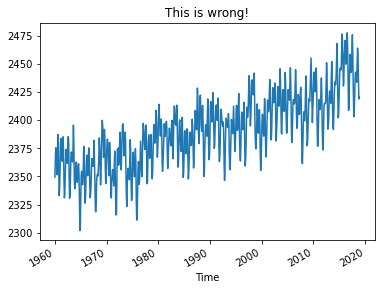

In [16]:
sst_mean = (ds.sst * weights).sum(dim=("lon", "lat")) / weights.sum(dim="lat")
sst_mean.plot()
plt.title("This is wrong!")

That would be wrong, however, because the denominator (`weights.sum(dim='lat')`)
needs to be expanded to include the `lon` dimension and modified to account for
the missing values (land points).

In general, weighted reductions on multidimensional arrays are complicated. To
make it a bit easier, Xarray provides a mechanism for weighted reductions. It
does this by creating a special intermediate `DataArrayWeighted` object, to
which different reduction operations can applied.


In [17]:
sst_weighted = ds.sst.weighted(weights)
sst_weighted

DataArrayWeighted with weights along dimensions: lat

Text(0.5, 1.0, 'Correct Global Mean SST')

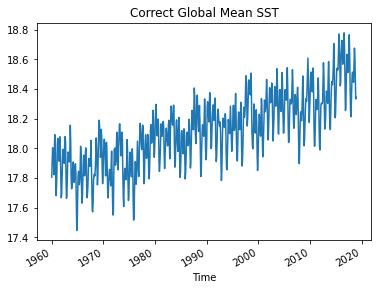

In [18]:
sst_weighted.mean(dim=("lon", "lat")).plot()
plt.title("Correct Global Mean SST")

## Groupby

Xarray copies Pandas' very useful groupby functionality, enabling the "split /
apply / combine" workflow on xarray DataArrays and Datasets.

To provide a physically motivated example, let's examine a timeseries of SST at
a single point.


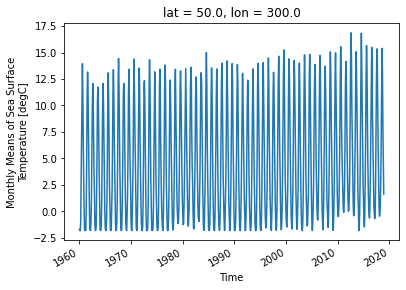

In [19]:
ds.sst.sel(lon=300, lat=50).plot()

As we can see from the plot, the timeseries at any one point is totally
dominated by the seasonal cycle. We would like to remove this seasonal cycle
(called the "climatology") in order to better see the long-term variaitions in
temperature. We can accomplish this using **groupby**.

Before moving forward, w note that xarray correctly parsed the time index,
resulting in a Pandas datetime index on the time dimension.


In [20]:
ds.time

<xarray.DataArray 'time' (time: 708)>
array(['1960-01-01T00:00:00.000000000', '1960-02-01T00:00:00.000000000',
       '1960-03-01T00:00:00.000000000', ..., '2018-10-01T00:00:00.000000000',
       '2018-11-01T00:00:00.000000000', '2018-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
Attributes:
    long_name:        Time
    delta_t:          0000-01-00 00:00:00
    avg_period:       0000-01-00 00:00:00
    prev_avg_period:  0000-00-07 00:00:00
    standard_name:    time
    axis:             T
    actual_range:     [19723. 80505.]
    _ChunkSizes:      1

The syntax of Xarray's groupby is almost identical to Pandas.


In [21]:
ds.groupby?

### Split Step

The most important argument is `group`: this defines the unique values we will
us to "split" the data for grouped analysis. We can pass either a DataArray or a
name of a variable in the dataset. Lets first use a DataArray. Just like with
Pandas, we can use the time indexe to extract specific components of dates and
times. Xarray uses a special syntax for this `.dt`, called the
`DatetimeAccessor`.


In [22]:
ds.time.dt

In [23]:
ds.time.dt.month

<xarray.DataArray 'month' (time: 708)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01

ds.time.dt.year


We can use these arrays in a groupby operation:


In [24]:
gb = ds.groupby(ds.time.dt.month)
gb

DatasetGroupBy, grouped over 'month' 
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

Xarray also offers a more concise syntax when the variable you're grouping on is
already present in the dataset. This is identical to the previous line:


In [25]:
gb = ds.groupby("time.month")
gb

DatasetGroupBy, grouped over 'month' 
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

Now that the data are split, we can manually iterate over the group. The
iterator returns the key (group name) and the value (the actual dataset
corresponding to that group) for each group.


In [26]:
for group_name, group_ds in gb:
    # stop iterating after the first loop
    break
print(group_name)
group_ds

1


<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 59)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1961-01-01 ... 2018-01-01
Data variables:
    sst      (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes:
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    geospatial_lon_min:              -1.0
    geospatial_lon_max:              359.0
    geospatial_laty_max:             89.0
    geospatial_laty_min:             -89.0
    geospatial_lat_max:              89.0
    geospatial_lat_min:              -89.0
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    cdm_data_type:                   Grid
    project:                         NOAA Extended Reconstructed Sea Surface ...
    original_publisher_url:          http://www.ncdc.noaa.gov
    References:                      https://www.ncdc.noaa.gov/data-access/ma...
    source:                          In situ data: ICOADS R3.0 before 2015, N...
    title:                           NOAA ERSSTv5 (in situ only)
    history:                         created 07/2017 by PSD data using NCEI's...
    institution:                     This version written at NOAA/ESRL PSD: o...
    citation:                        Huang et al, 2017: Extended Reconstructe...
    platform:                        Ship and Buoy SSTs from ICOADS R3.0 and ...
    standard_name_vocabulary:        CF Standard Name Table (v40, 25 January ...
    processing_level:                NOAA Level 4
    Conventions:                     CF-1.6, ACDD-1.3
    metadata_link:                   :metadata_link = https://doi.org/10.7289...
    creator_name:                    Boyin Huang (original)
    date_created:                    2017-06-30T12:18:00Z (original)
    product_version:                 Version 5
    creator_url_original:            https://www.ncei.noaa.gov
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2020-07-07
    DODS_EXTRA.Unlimited_Dimension:  time

### Apply & Combine

Now that we have groups defined, it's time to "apply" a calculation to the
group. Like in Pandas, these calculations can either be:

- _aggregation_: reduces the size of the group
- _transformation_: preserves the group's full size

At then end of the apply step, xarray will automatically combine the aggregated
/ transformed groups back into a single object.

The most fundamental way to apply is with the `.map` method.


In [27]:
gb.map?

#### Aggregations

`.apply` accepts as its argument a function. We can pass an existing function:


In [28]:
gb.map(np.mean)

<xarray.Dataset>
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (month) float32 13.659467 13.768469 13.764702 ... 13.506328 13.5293

Because we specified no extra arguments (like `axis`) the function was applied
over all space and time dimensions. This is not what we wanted. Instead, we
could define a custom function. This function takes a single argument--the group
dataset--and returns a new dataset to be combined:


In [29]:
def time_mean(a):
    return a.mean(dim="time")


gb.map(time_mean)

/home/travis/miniconda/envs/xarray/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, month: 12)
Coordinates:
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (month, lat, lon) float32 -1.8000009 -1.8000009 ... nan nan

Like Pandas, xarray's groupby object has many built-in aggregation operations
(e.g. `mean`, `min`, `max`, `std`, etc):


In [30]:
# this does the same thing as the previous cell
ds_mm = gb.mean(dim="time")
ds_mm

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, month: 12)
Coordinates:
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (month, lat, lon) float32 -1.8000009 -1.8000009 ... nan nan

So we did what we wanted to do: calculate the climatology at every point in the
dataset. Let's look at the data a bit.

_Climatlogy at a specific point in the North Atlantic_


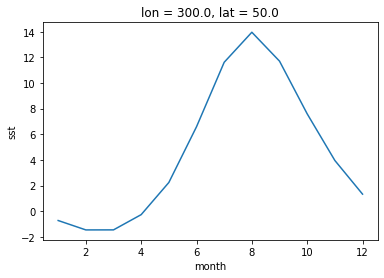

In [31]:
ds_mm.sst.sel(lon=300, lat=50).plot()

_Zonal Mean Climatolgoy_


/home/travis/miniconda/envs/xarray/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


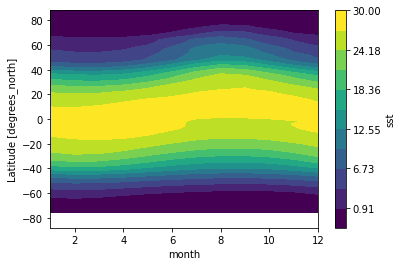

In [32]:
ds_mm.sst.mean(dim="lon").plot.contourf(x="month", levels=12, vmin=-2, vmax=30)

_Difference between January and July Climatology_


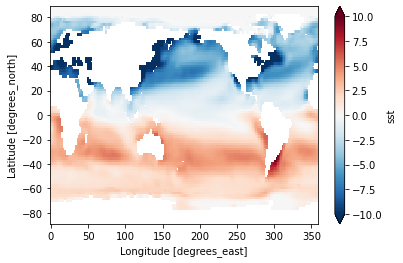

In [33]:
(ds_mm.sst.sel(month=1) - ds_mm.sst.sel(month=7)).plot(vmax=10)

#### Transformations

Now we want to _remove_ this climatology from the dataset, to examine the
residual, called the _anomaly_, which is the interesting part from a climate
perspective. Removing the seasonal climatology is a perfect example of a
transformation: it operates over a group, but doesn't change the size of the
dataset. Here is one way to code it


In [34]:
def remove_time_mean(x):
    return x - x.mean(dim="time")


ds_anom = ds.groupby("time.month").map(remove_time_mean)
ds_anom

/home/travis/miniconda/envs/xarray/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 708)
Coordinates:
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
Data variables:
    sst      (time, lat, lon) float32 9.536743e-07 9.536743e-07 ... nan nan

Xarray makes these sorts of transformations easy by supporting _groupby
arithmetic_. This concept is easiest explained with an example:


In [35]:
gb = ds.groupby("time.month")
ds_anom = gb - gb.mean(dim="time")
ds_anom

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 708)
Coordinates:
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lat, lon) float32 9.536743e-07 9.536743e-07 ... nan nan

Now we can view the climate signal without the overwhelming influence of the
seasonal cycle.

_Timeseries at a single point in the North Atlantic_


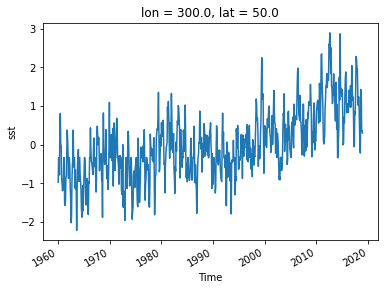

In [36]:
ds_anom.sst.sel(lon=300, lat=50).plot()

_Difference between Jan. 1 2018 and Jan. 1 1960_


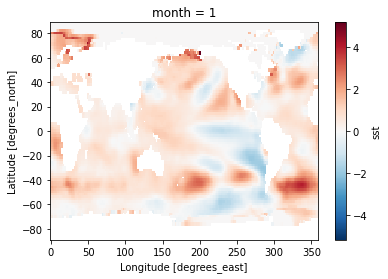

In [37]:
(ds_anom.sel(time="2018-01-01") - ds_anom.sel(time="1960-01-01")).sst.plot()

## Grouby-Related: Resample, Rolling, Coarsen

Resample in xarray is nearly identical to Pandas. It is effectively a group-by
operation, and uses the same basic syntax. It can be applied only to time-index
dimensions. Here we compute the five-year mean.


In [38]:
resample_obj = ds_anom.resample(time="5Y")
resample_obj

DatasetResample, grouped over '__resample_dim__' 
13 groups with labels 1960-12-31, ..., 2020-12-31.

In [39]:
ds_anom_resample = resample_obj.mean(dim="time")
ds_anom_resample

/home/travis/miniconda/envs/xarray/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 13)
Coordinates:
  * time     (time) datetime64[ns] 1960-12-31 1965-12-31 ... 2020-12-31
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
Data variables:
    sst      (time, lat, lon) float32 -0.0006173253 -0.0006062587 ... nan nan

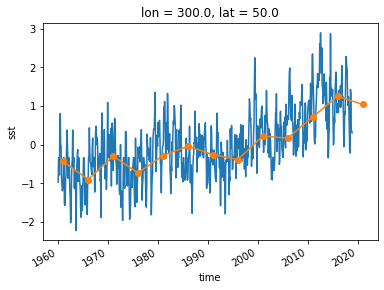

In [40]:
ds_anom.sst.sel(lon=300, lat=50).plot()
ds_anom_resample.sst.sel(lon=300, lat=50).plot(marker="o")

<div class="alert alert-info">
    <strong>Note:</strong> <code>resample</code> only works with proper datetime indexes.
</div>

Rolling is also similar to pandas, but can be applied along any dimension. It
works with logical coordinates.


In [41]:
ds_anom_rolling = ds_anom.rolling(time=12, center=True).mean()
ds_anom_rolling

/home/travis/miniconda/envs/xarray/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 708)
Coordinates:
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

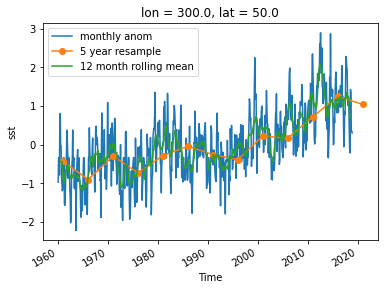

In [42]:
ds_anom.sst.sel(lon=300, lat=50).plot(label="monthly anom")
ds_anom_resample.sst.sel(lon=300, lat=50).plot(
    marker="o", label="5 year resample"
)
ds_anom_rolling.sst.sel(lon=300, lat=50).plot(label="12 month rolling mean")
plt.legend()

`coarsen` does something similar to `resample`, but without being aware of time.
It operates on logical coordinates only but can work on multiple dimensions at a
time.


/home/travis/miniconda/envs/xarray/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


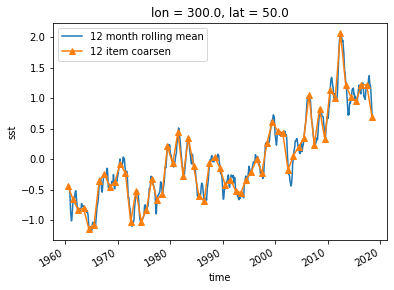

In [43]:
ds_anom_coarsen_time = ds_anom.coarsen(time=12).mean()

ds_anom_rolling.sst.sel(lon=300, lat=50).plot(label="12 month rolling mean")
ds_anom_coarsen_time.sst.sel(lon=300, lat=50).plot(
    marker="^", label="12 item coarsen"
)
plt.legend()

In [44]:
%%expect_exception
ds_anom_coarsen_space = ds_anom.coarsen(lon=4, lat=4).mean()

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-44-f690a99950fa> in <module>
----> 1 ds_anom_coarsen_space = ds_anom.coarsen(lon=4, lat=4).mean()

~/miniconda/envs/xarray/lib/python3.8/site-packages/xarray/core/rolling.py in wrapped_func(self, **kwargs)
    671             reduced = {}
    672             for key, da in self.obj.data_vars.items():
--> 673                 reduced[key] = da.variable.coarsen(
    674                     self.windows, func, self.boundary, self.side, **kwargs
    675                 )

~/miniconda/envs/xarray/lib/python3.8/site-packages/xarray/core/variable.py in coarsen(self, windows, func, boundary, side, **kwargs)
   1926             return self.copy()
   1927 
-> 1928         reshaped, axes = self._coarsen_reshape(windows, boundary, side)
   1929         if isinstance(func, str):
   1930             name = func

~/miniconda/envs/xarray/

In [45]:
ds_anom_coarsen_space = (
    ds_anom.isel(lat=slice(0, -1)).coarsen(lon=4, lat=4).mean()
)
ds_anom_coarsen_space

/home/travis/miniconda/envs/xarray/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:  (lat: 22, lon: 45, time: 708)
Coordinates:
  * lon      (lon) float32 3.0 11.0 19.0 27.0 35.0 ... 331.0 339.0 347.0 355.0
  * lat      (lat) float32 85.0 77.0 69.0 61.0 53.0 ... -59.0 -67.0 -75.0 -83.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lat, lon) float32 -0.00022904575 -0.022380486 ... nan nan

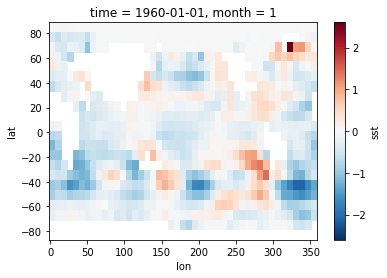

In [46]:
ds_anom_coarsen_space.sst.isel(time=0).plot()

## Exercise

Load the following "basin mask" dataset, and use it to take a weighted average
of SST in each ocean basin. Figure out which ocean basins are the warmest and
coldest.

**Hint:** you will first need to align this dataset with the SST dataset. Use
what you learned in the "indexing and alignment" lesson.


In [47]:
basin = xr.open_dataset(
    "http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/.Masks/.basin/dods"
)
basin

<xarray.Dataset>
Dimensions:  (X: 360, Y: 180, Z: 33)
Coordinates:
  * Y        (Y) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * Z        (Z) float32 0.0 10.0 20.0 30.0 50.0 ... 4000.0 4500.0 5000.0 5500.0
  * X        (X) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    basin    (Z, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL